In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt


In [18]:
# mnist -> tensors
transform= transforms.ToTensor()
traindata= datasets.MNIST(root='../Data',train=True,download=True,transform=transform)
traindata

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [19]:
testdata=datasets.MNIST(root='../Data',train=False,download=True,transform=transform)
testdata

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [20]:
type(traindata)

torchvision.datasets.mnist.MNIST

In [21]:
traindata[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [22]:
image,label=traindata[0]
image.shape

torch.Size([1, 28, 28])

In [23]:
label

5

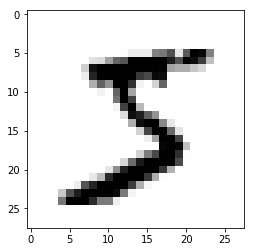

In [24]:
plt.imshow(image.reshape((28,28)),cmap='gist_yarg')

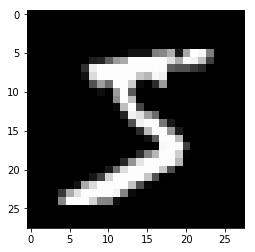

In [25]:
plt.imshow(image.reshape((28,28)),cmap='gray')

# loading training data in batches

In [26]:
torch.manual_seed(101)
trainloader=DataLoader(traindata,batch_size=100,shuffle=True)
testloader=DataLoader(testdata,batch_size=500,shuffle=False)

In [27]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

#for viewing firstbatch
for images,labels in trainloader:
    break
    
images.shape
    


torch.Size([100, 1, 28, 28])

In [28]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


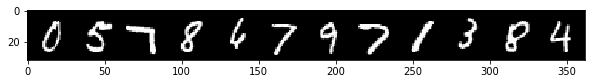

In [29]:
# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from ColorWidthHeight to WidthHeightColor
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# defining model

In [33]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self,in_sz=784,out_sz=10,layers=[120,84]):
        super().__init__()
        self.fc1= nn.Linear(in_sz,layers[0])
        self.fc2= nn.Linear(layers[0],layers[1])
        self.fc3= nn.Linear(layers[1],out_sz)
        
    def forward(self,X):
        X= F.relu(self.fc1(X))
        X= F.relu(self.fc2(X))
        X= self.fc3(X)
        
        return F.log_softmax(X,dim=1) #multi clss classification

In [34]:
torch.manual_seed(101)
model= MultiLayerPerceptron()
model

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [36]:
#  to view total no of params (weights,biases) in our ann
for param in model.parameters():
    print(param.numel())
#105,214 total params thats a lot xP

94080
120
10080
84
840
10


In [37]:
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(),lr=0.001)

In [39]:
images.shape #--> [100,784] flattening out

torch.Size([100, 1, 28, 28])

In [41]:
images.view(100,-1).shape

torch.Size([100, 784])

In [46]:
#training the model
import time
starttime= time.time()

epochs=10
#trackers
trainlosses=[]
testlosses=[]
traincorrect=[]
testcorrect=[]

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    
    for b,(X_train,y_train) in enumerate(trainloader):
        b+=1
        y_pred= model(X_train.view(100,-1))
        loss=criterion(y_pred,y_train)
        
        predicted= torch.max(y_pred.data,1)[1] #gets the max prob among 10 output neurons and assoc with the label/number
        batch_corr= (predicted==y_train).sum()# sum of correctly pred values in training in a batch
        trn_corr+=batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            accuracy= trn_corr.item()*100/(100*b)
            print(f'Epoch {i} batch {b} loss:{loss.item()} acc:{accuracy}')
    
    trainlosses.append(loss)
    traincorrect.append(trn_corr)
    
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(testloader):
            y_val=model(X_test.view(500,-1))
            predicted= torch.max(y_val.data,1)[1]
            tst_corr+=(predicted==y_test).sum()
    loss= criterion(y_val,y_test)
    testlosses.append(loss)
    testcorrect.append(tst_corr)
    

totaltime= time.time()-starttime
print(f'Duration:{totaltime/60}mins')

Epoch 0 batch 200 loss:0.03090769611299038 acc:98.25
Epoch 0 batch 400 loss:0.05024134740233421 acc:98.2175
Epoch 0 batch 600 loss:0.028015730902552605 acc:98.11333333333333
Epoch 1 batch 200 loss:0.05219306796789169 acc:98.545
Epoch 1 batch 400 loss:0.03248562663793564 acc:98.54
Epoch 1 batch 600 loss:0.02947121672332287 acc:98.48333333333333
Epoch 2 batch 200 loss:0.029994482174515724 acc:99.05
Epoch 2 batch 400 loss:0.026400305330753326 acc:98.85
Epoch 2 batch 600 loss:0.07027994841337204 acc:98.80666666666667
Epoch 3 batch 200 loss:0.031352147459983826 acc:99.2
Epoch 3 batch 400 loss:0.06004112586379051 acc:99.0675
Epoch 3 batch 600 loss:0.027864620089530945 acc:99.02333333333333
Epoch 4 batch 200 loss:0.01717228814959526 acc:99.025
Epoch 4 batch 400 loss:0.024260111153125763 acc:99.0925
Epoch 4 batch 600 loss:0.006908196955919266 acc:99.07166666666667
Epoch 5 batch 200 loss:0.0034939178731292486 acc:99.395
Epoch 5 batch 400 loss:0.011082739569246769 acc:99.365
Epoch 5 batch 600 lo

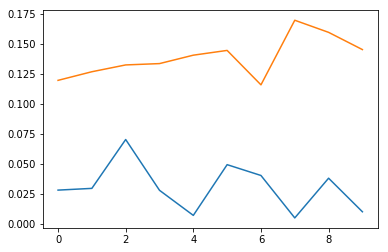

In [49]:
plt.plot(trainlosses,label='trainloss')
plt.plot(testlosses,label='testloss')